<br>
<br>
<h1><center> Risk Sensitivity and Theory of Mind in Human Coordination</h1></center>

<center>Pedro L. Ferreira$^1$, Francisco C. Santos$^1$, Sérgio Pequito$^2$</center>
<br>
<center>$^1$INESC-ID and Instituto Superior Técnico,  Universidade de Lisboa,  2744-016 Porto Salvo,Portugal</center>
<center>$^2$Delft Center for Systems and Control,  Technische Universiteit Delft,  Mekelweg 22628 CDDelft, Netherlands</center>
<hr>

<center><h1>Markov Stag Hunt Game with Cumulative Prospect Theory</center>
<br>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import pickle
from multiprocessing.dummy import Pool
from itertools import repeat
from scipy.optimize import minimize

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 11}
plt.rc('font', **font)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cmap='inferno'

# Path to save pickles
path = "pickles"

<hr>
<br>
<br>
<center><h2> Utility Function </h2></center>
<br>

In [3]:
def util_pos(x):
    return x

def util_neg(x):
    return x
#     return 2*x**0.85

<hr>
<br>
<br>
<center><h2> Probability Weighting Function </h2></center>
<br>

In [4]:
def w(k):
    return 0.00231*k**0.05 + 0.00128*k**0.1 + 0.19578*k**0.35 + 0.59897*k**0.4 + 0.15968*k**0.95 + 0.03318*k**3 + 0.00847*k**23
#     return 0.89986*k**0.05 + -1.71521*k**0.1 + 8.11307*k**0.35 + -7.98148*k**0.4 + 1.13561*k**0.95 + 0.50992*k**3 + 0.03636*k**23
#     return -0.56256*k**0.05 + 1.02308*k**0.1 + -3.89719*k**0.35 + 3.91168*k**0.4 + 0.23234*k**0.95 + 0.23041*k**3 + 0.05572*k**23
#     return 0.04899*k**0.05 + -0.09353*k**0.1 + 0.3802*k**0.35 + -0.33697*k**0.4 + 0.93308*k**0.95 + 0.06062*k**3 + 0.00762*k**23
#     k = np.maximum(0,k)
#     return -0.35688*k**0.05 + 0.64982*k**0.1 + -2.54516*k**0.35 + 2.65633*k**0.4 + 0.31362*k**0.95 + 0.21693*k**3 + 0.06532*k**23 # Alpha = 1

# def W_approx_neg(k):
# #     return 0.00231*k**0.05 + 0.00128*k**0.1 + 0.19578*k**0.35 + 0.59897*k**0.4 + 0.15968*k**0.95 + 0.03318*k**3 + 0.00847*k**23
# #     return 0.89986*k**0.05 + -1.71521*k**0.1 + 8.11307*k**0.35 + -7.98148*k**0.4 + 1.13561*k**0.95 + 0.50992*k**3 + 0.03636*k**23
# #     return -0.56256*k**0.05 + 1.02308*k**0.1 + -3.89719*k**0.35 + 3.91168*k**0.4 + 0.23234*k**0.95 + 0.23041*k**3 + 0.05572*k**23
# #     return 0.04899*k**0.05 + -0.09353*k**0.1 + 0.3802*k**0.35 + -0.33697*k**0.4 + 0.93308*k**0.95 + 0.06062*k**3 + 0.00762*k**23
#     return -0.35688*k**0.05 + 0.64982*k**0.1 + -2.54516*k**0.35 + 2.65633*k**0.4 + 0.31362*k**0.95 + 0.21693*k**3 + 0.06532*k**23 # Alpha = 1


<hr>
<br>
<br>
<center><h2> Calculation of CPT-Value in Markov Game</h2></center>
<br>
<center>and Auxiliary Functions
<br>

In [5]:
def total_cum_dist(s_values,s_probs):
    return np.concatenate(([0],np.cumsum(s_probs)[:-1]))

def CPT_value(N,P,R,beta,baseline,util_pos,util_neg,W_pos,W_neg,max_iter=150,stop_error=1e-2):
    '''Calculates the Cumulative Prospect Theory value (CPT-value) for a given MDP.'''
    
    # Initialize variables
    value = np.zeros(N)
    value_new = np.zeros(N)
    policy = np.zeros((N,len(P)))
    optimal_values = []
    optimal_policies = []
    
    # Initialize bounds and constraints of optimization
    def constraint(policy): # probabilities must sum to 1
        return np.sum(policy)-1.0


    bounds = [(0,1)]*3
    constraints = [{'type':'eq','fun':constraint}]
    p0=np.round(np.ones(len(P))/len(P),10)

    for t in range(max_iter):
        print('[{}/{}]'.format(t+1,max_iter),end='\r')
        
        U_all = np.expand_dims(R,1)+beta*value-baseline
        
        for s in range(N):
            u_pos = util_pos( np.maximum(np.zeros(N),U_all[s]))
            u_neg = util_neg(-np.minimum(np.zeros(N),U_all[s]))
            
            
            
            u_pos_sargs = np.argsort(u_pos)
            u_neg_sargs = np.argsort(u_neg)
            
            atoms_u_pos = u_pos[u_pos_sargs]
            atoms_u_neg = u_neg[u_neg_sargs]
            
            zero_atoms_pos = np.concatenate(([0],atoms_u_pos))
            zero_atoms_neg = np.concatenate(([0],atoms_u_neg))
            intervals_pos = zero_atoms_pos[1:]-zero_atoms_pos[:-1]
            intervals_neg = zero_atoms_neg[1:]-zero_atoms_neg[:-1]
            
            Q_pos = np.zeros((len(P),N))
            Q_neg = np.zeros((len(P),N))

            for action,P_a in enumerate(P):
                atoms_Ps_pos = P_a[s][u_pos_sargs]
                atoms_Ps_neg = P_a[s][u_neg_sargs]
                Q_pos[action] = 1-total_cum_dist(atoms_u_pos,atoms_Ps_pos)
                Q_neg[action] = 1-total_cum_dist(atoms_u_neg,atoms_Ps_neg)
                Q_pos[action] = np.maximum(np.zeros_like(Q_pos[action]),Q_pos[action])
                Q_neg[action] = np.maximum(np.zeros_like(Q_neg[action]),Q_neg[action])

            p0=np.round(np.ones(len(P))/len(P),10) if t==0 else optimal_policies[-1][s]
            err_count = 0
            
            while True:
                
                objective = lambda p:-(W_pos(np.tensordot(Q_pos,p,axes=(0,0)))@intervals_pos - W_neg(np.tensordot(Q_neg,p,axes=(0,0)))@intervals_neg)
                                      
                solution = minimize(objective,x0=p0,bounds=bounds,constraints=constraints,method='SLSQP')
                
                if solution.success == True:
                    policy[s] = np.round(solution.x,10)
                    value_new[s] = -solution.fun
                    break
                else:
                    err_count += 1
                    p0=np.random.uniform(0,1,size=3); p0[2] = 1 - p0[0] - p0[1];
                    print(solution.message,end=' {}                                \r'.format(err_count))
        
        error = np.sum(np.abs(value_new - value))
        print('[{}/{}] Error: {:.3f} Mag: {:.3f}'.format(t+1,max_iter,error,np.sum(np.abs(value_new))),end='                         \r')
        value = value_new.copy()
        optimal_values.append(value.copy())
        optimal_policies.append(policy.copy())
        if(error<stop_error):
            break
    optimal_values = np.array(optimal_values)
    optimal_policies = np.array(optimal_policies)
    return optimal_values,optimal_policies

def choose_best(values,policies):
    optimal_index = np.argmax(np.sum((np.abs(values)),axis=1))
    optimal_value = values[optimal_index]
    optimal_policy = policies[optimal_index]
    return optimal_index,optimal_value,optimal_policy

def get_P1(P_both,policy2):
    return np.einsum('abcd,ca->bcd',P_both,policy2)
def get_P2(P_both,policy1):
    return np.einsum('abcd,cb->acd',P_both,policy1)

def get_markov_chain(P_aa,policy1,policy2):
    return np.einsum('abcd,cb,ca->cd',P_aa,policy1,policy2)
    
def get_agent_density(P_markovchain,time_step,initial_distribution):
    return np.einsum('ij,j->i',
                     np.linalg.matrix_power(P_markovchain.T,time_step),
                     initial_distribution)

def plot_policy(policy):
    f,axes = plt.subplots(1,3,figsize=(15,5))
    titles = ['Pr(Left)','Pr(Stay)','Pr(Right)']
    for i,(ax,title) in enumerate(zip(axes,titles)):
        ax.set_title(title)
        ax.imshow(policy.reshape(N,N,3)[:,:,i].T,origin='lower',cmap=cmap)
        ax.set_xticks(range(N))
        ax.set_yticks(range(N))
        ax.set_xlabel('State of agent 1')
        ax.set_ylabel('State of agent 2')
    plt.tight_layout()
    plt.show()
    
def swap_policy_owner(policy):
    return policy.reshape(N,N,3).transpose(1,0,2).reshape(-1,3)

def plot_density(P_markov_chain,initial_distribution=None,times=[1,10,128]):
    
    initial_distribution = np.ones(N*N)/(N*N)
    f,axes = plt.subplots(1,len(times),figsize=(15,5))
    for ax,t in zip(axes,times):
        ax.set_title('Agent density at time {}'.format(t))
        ax.imshow(get_agent_density(P_markov_chain,t,initial_distribution).reshape(N,N).T,origin='lower',cmap=cmap)
        ax.set_xlabel('State of agent 1')
        ax.set_ylabel('State of agent 2')
        ax.set_xticks(range(16))
        ax.set_yticks(range(16))
    plt.tight_layout()
    plt.show()

    
def plot_equilibrium_density(P_markov_chain,figsize=(10,5),clim=None):
    initial_distribution = np.ones(N*N)/(N*N)
    plt.figure(figsize=figsize)
    plt.title('Agent density at equilibrium')
    plt.imshow(get_agent_density(P_markov_chain,1000,initial_distribution).reshape(N,N).T,origin='lower',cmap=cmap)
    plt.xlabel('State of agent 1')
    plt.ylabel('State of agent 2')
    plt.colorbar()
    if clim!=None:
        plt.clim(*clim)
    plt.xticks(range(16))
    plt.yticks(range(16))
    plt.tight_layout()
    plt.show()

<hr>
<br>
<br>
<center><h2> Definition of Markov Stag Hunt Game</h2></center>
<br>

In [7]:
N = 16
r = np.zeros(N)

hare_reward = 1
stag_reward = 5

r[3] = hare_reward
r[11] = stag_reward

P_L = np.zeros((N,N))
P_S = np.zeros((N,N))
P_R = np.zeros((N,N))

for i in range(N):
    P_S[i,i]=1
    if i>0:
        P_L[i,i-1]=1
    else:
        P_L[i,i]=1
    if i<N-1:
        P_R[i,i+1]=1
    else:
        P_R[i,i]=1

def add_noise(noise,P_L=P_L,P_S=P_S,P_R=P_R):
    p_L,p_S,p_R = P_L.copy(),P_S.copy(),P_R.copy()
    p_L = (1-noise)*P_L.copy() + noise*(P_S.copy() + P_R.copy())/2
    p_S = (1-noise)*P_S.copy() + noise*(P_L.copy() + P_R.copy())/2
    p_R = (1-noise)*P_R.copy() + noise*(P_S.copy() + P_L.copy())/2
    return p_L,p_S,p_R

P_L,P_S,P_R = add_noise(0.3)

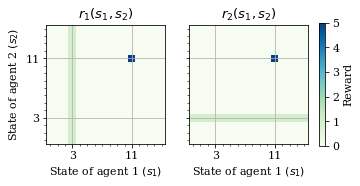

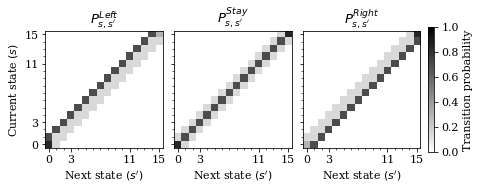

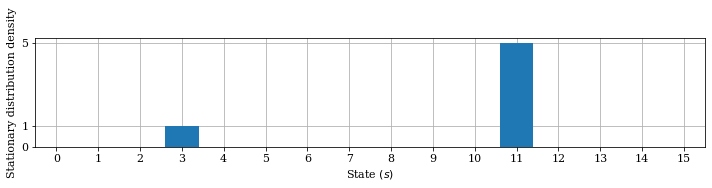

In [9]:
P1 = [np.kron(np.eye(N),P_) for P_ in [P_L,P_S,P_R]]
P2 = [np.kron(P_,np.eye(N)) for P_ in [P_L,P_S,P_R]]
P_both = [[(p1+p2)/2 for p2 in P2] for p1 in P1] # [a1,a2,s,s']

R1 = np.zeros((N,N))
R1[3,:] = hare_reward
R1[11,11] = stag_reward
R1=R1.flatten()
R2 = np.zeros((N,N))
R2[:,3] = hare_reward
R2[11,11] = stag_reward
R2=R2.flatten()

beta=0.9
baseline=0
max_iter=100

f,axes = plt.subplots(1,2,figsize=(5,2.5),sharey=True)
ax1,ax2=axes
ax=ax1
ax.imshow(R1.reshape(N,N).T,cmap='GnBu',origin='lower')
ax.set_xlabel(r'State of agent 1 $(s_1)$')
ax.set_ylabel(r'State of agent 2 $(s_2)$')

ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
ax.set_xticks([3,11], minor=False)
ax.xaxis.grid(True, which='major',c=np.array([1,1,1])*0.7)
ax.xaxis.grid(False, which='minor')
ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
ax.set_yticks([3,11], minor=False)
ax.yaxis.grid(True, which='major',c=np.array([1,1,1])*0.7)
ax.yaxis.grid(False, which='minor')

ax.set_title(r'$r_1(s_1,s_2)$')

ax=ax2
im = ax.imshow(R2.reshape(N,N).T,cmap='GnBu',origin='lower')
ax.set_xlabel(r'State of agent 1 $(s_1)$')

ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
ax.set_xticks([3,11], minor=False)
ax.xaxis.grid(True, which='major',c=np.array([1,1,1])*0.7)
ax.xaxis.grid(False, which='minor')
ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
ax.set_yticks([3,11], minor=False)
ax.yaxis.grid(True, which='major',c=np.array([1,1,1])*0.7)
ax.yaxis.grid(False, which='minor')

ax.set_title(r'$r_2(s_1,s_2)$')
plt.colorbar(im,ax=axes.ravel(),fraction=0.022, pad=0.04,label="Reward")
plt.savefig('MarkovGame/reward_functions.pdf')
plt.show()

f,axes = plt.subplots(1,3,figsize=(7,2.3),sharey=True)
ax1,ax2,ax3=axes
ax1.imshow(P_L,cmap='binary',origin='lower',vmin=0, vmax=1)
ax1.set_title(r"$P^{Left}_{s,s'}$")
im2 = ax2.imshow(P_S,cmap='binary',origin='lower',vmin=0, vmax=1)
ax2.set_title(r"$P^{Stay}_{s,s'}$")
im3 = ax3.imshow(P_R,cmap='binary',origin='lower',vmin=0, vmax=1)
ax3.set_title(r"$P^{Right}_{s,s'}$")

ax1.set_xlabel(r"Next state $(s')$")
ax2.set_xlabel(r"Next state $(s')$")
ax3.set_xlabel(r"Next state $(s')$")
ax1.set_ylabel(r'Current state $(s)$')

ax1.set_xticks(range(N))
ax2.set_xticks(range(N))
ax3.set_xticks(range(N))
ax1.set_yticks(range(N))
ax2.set_yticks(range(N))
ax3.set_yticks(range(N))
for ax in axes:
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([0,3,11,15], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([0,3,11,15], minor=False)

plt.subplots_adjust(wspace=0.1,hspace=1)
f.colorbar(im3, ax=axes.ravel().tolist(),fraction=0.02, pad=0.02,label="Transition probability")
plt.savefig('MarkovGame/transition_probabilities.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,2))
plt.bar(range(N),r,zorder=10)
plt.xticks(range(N))
plt.xlim(-0.5,15.5)
plt.xlabel(r'State $(s)$')
plt.yticks([0,hare_reward,stag_reward])
plt.ylabel(r'Stationary distribution density')
plt.grid()
plt.savefig('MarkovGame/rewardHistogram.pdf',bbox_inches='tight')

plt.show()

<center><h1>Results - Expected Utility Theory

policy sums to 1? TrueMag: 747.566                          


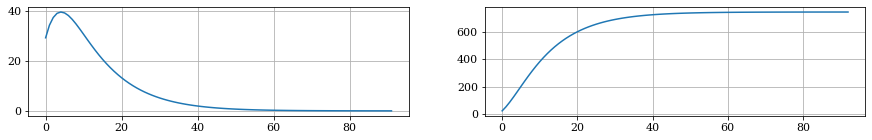

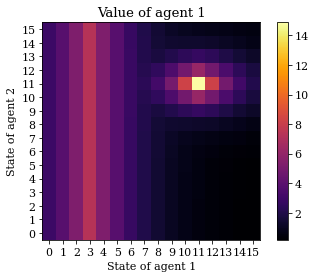

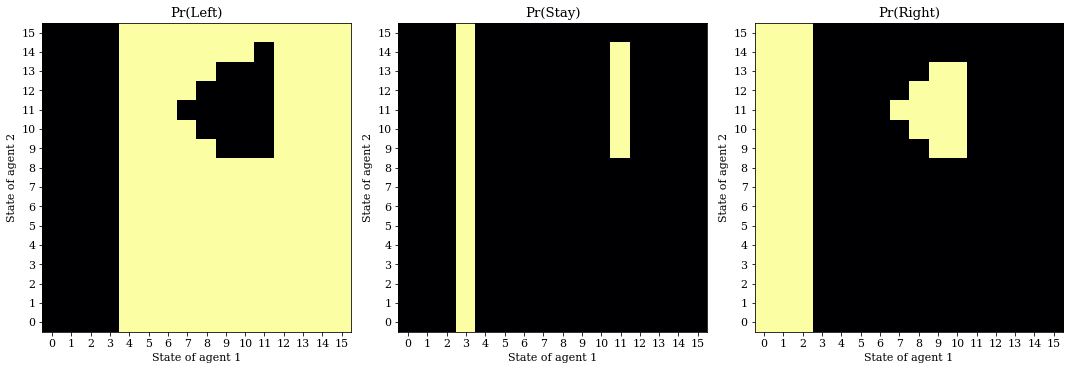

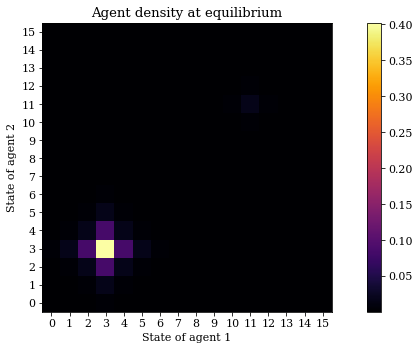

policy sums to 1? TrueMag: 1217.344                          


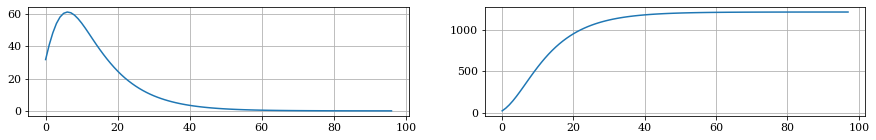

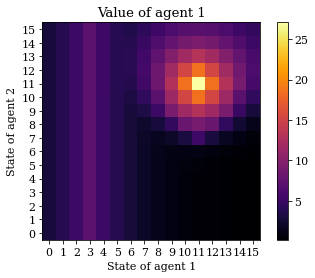

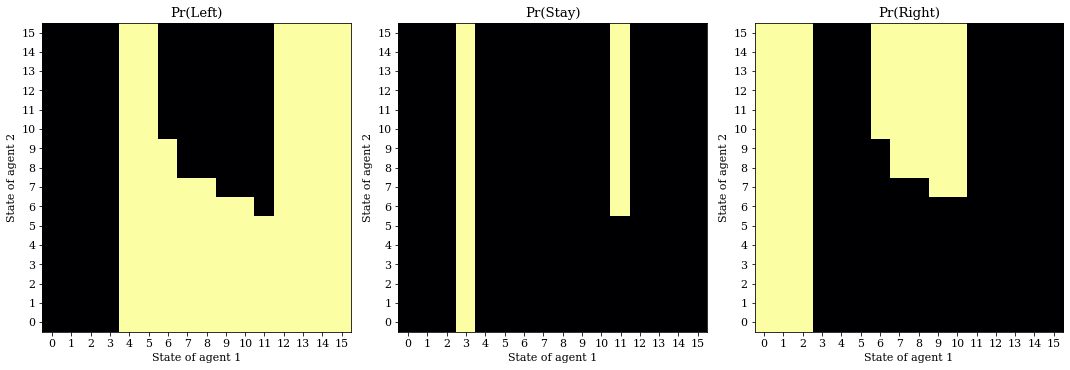

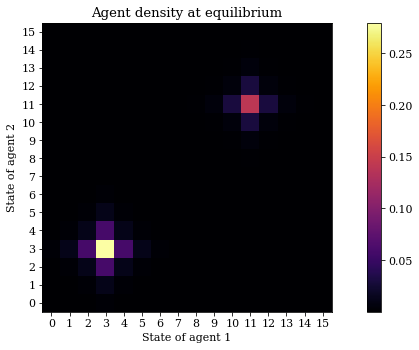

policy sums to 1? TrueMag: 1327.883                          


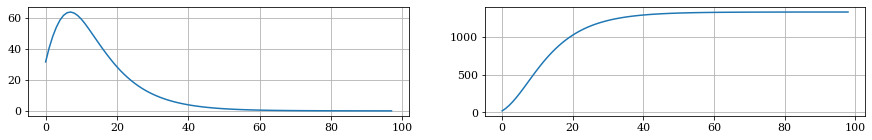

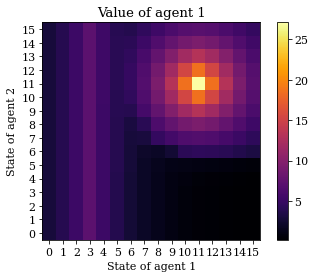

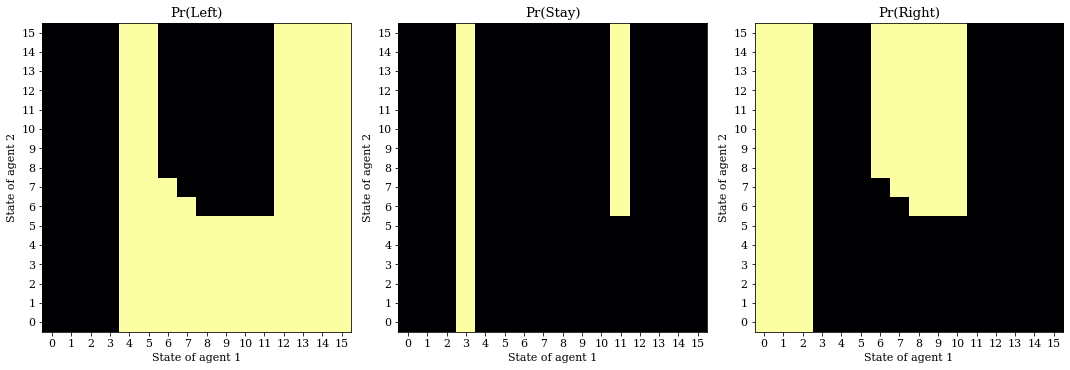

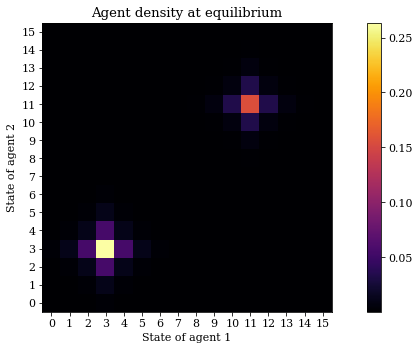

policy sums to 1? True Mag: 1338.666                         


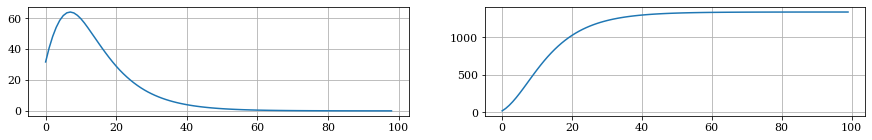

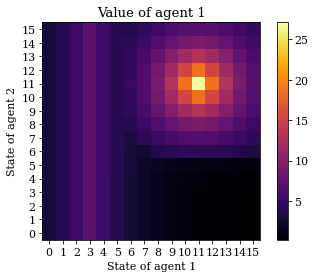

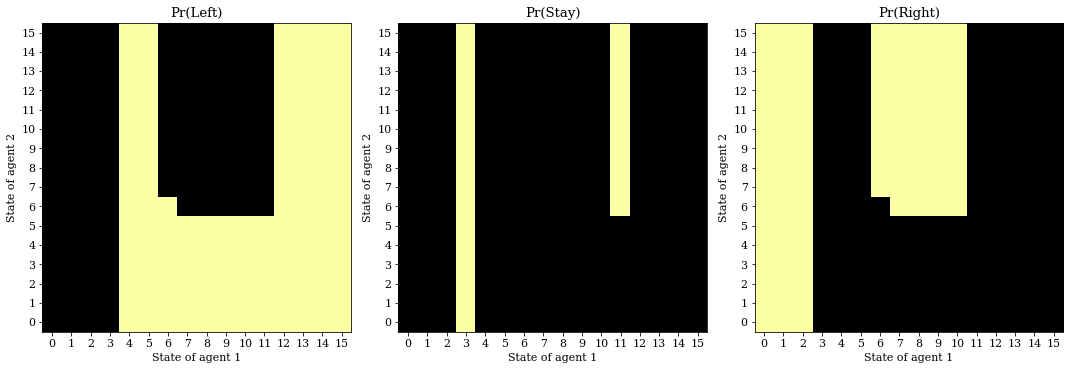

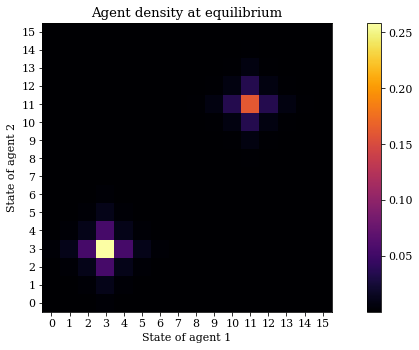

policy sums to 1? True Mag: 1340.374                         


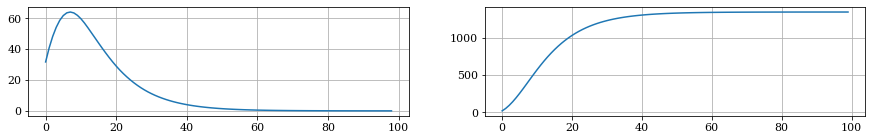

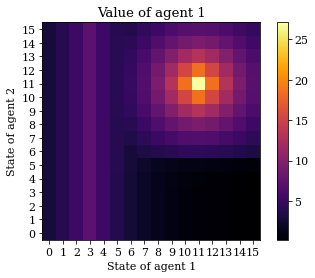

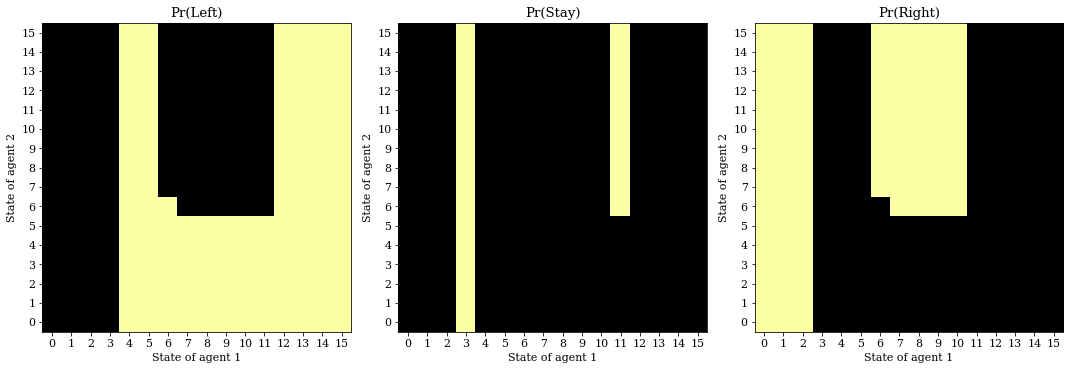

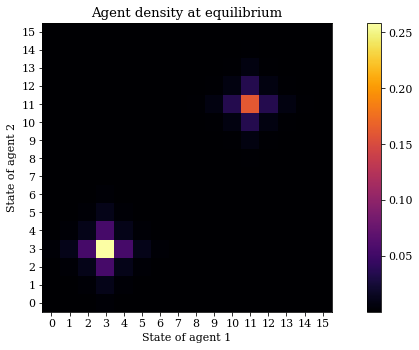

In [10]:
random_policy = np.ones((N*N,3))/3

EUT_k_pols = []
EUT_k_vals = []
EUT_k_opt_pols = []
EUT_k_opt_vals = []

for k in range(5):
    baseline_policy = random_policy if len(EUT_k_opt_pols)==0 else EUT_k_opt_pols[-1].copy()
    transformed_P1 = get_P1(P_both,swap_policy_owner(baseline_policy))
    vals, pols = CPT_value(N=N*N,P=transformed_P1,R=R1,beta=beta,baseline=baseline,
                           util_pos=util_pos,
                           util_neg=util_neg,
                           W_pos=lambda x:x,
                           W_neg=lambda x:x,
                           max_iter=400)
    _,opt_val,opt_pol = choose_best(vals,pols)
    EUT_k_pols.append(pols)
    EUT_k_vals.append(vals)
    EUT_k_opt_pols.append(opt_pol)
    EUT_k_opt_vals.append(opt_val)

    # Validate output (sanity check)
    print('policy sums to 1?',(np.sum(opt_pol,axis=1)==1).all())
    errors = np.sum(np.abs(vals[1:]-vals[:-1]),axis=1)
    f,(ax1,ax2)=plt.subplots(1,2,figsize=(15,2))
    ax1.plot(errors)
    ax1.grid()
    ax2.plot(np.sum(np.abs(vals),axis=1))
    ax2.grid()
    plt.show()

    plt.figure()
    plt.title('Value of agent 1')
    plt.imshow(opt_val.reshape(N,N).T,cmap=cmap,origin='lower')
    plt.xlabel('State of agent 1')
    plt.ylabel('State of agent 2')
    plt.xticks(range(16))
    plt.yticks(range(16))
    plt.colorbar()
    plt.show()

    plot_policy(opt_pol)
    q = get_markov_chain(P_both,opt_pol,swap_policy_owner(opt_pol))
    plot_equilibrium_density(q)
    
#     q2 = get_markov_chain(P_both,opt_pol,swap_policy_owner(baseline_policy))
#     plot_equilibrium_density(q2)

In [78]:
pickle.dump(EUT_k_pols,    open(path+'/EUT/EUT_k_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))
pickle.dump(EUT_k_vals,    open(path+'/EUT/EUT_k_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))
pickle.dump(EUT_k_opt_pols,open(path+'/EUT/EUT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))
pickle.dump(EUT_k_opt_vals,open(path+'/EUT/EUT_k_opt_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))

<center><h1>Results - Cumulative Prospect Theory

0


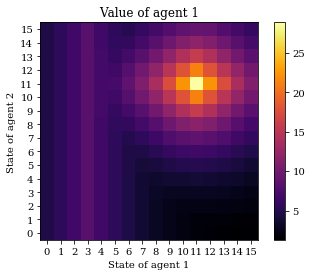

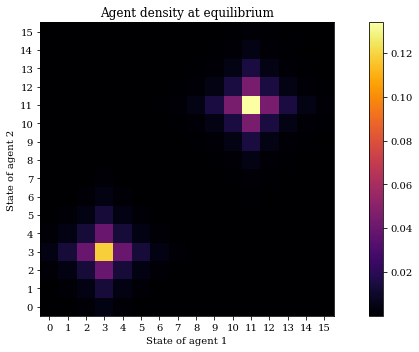

1


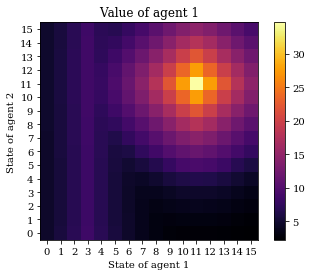

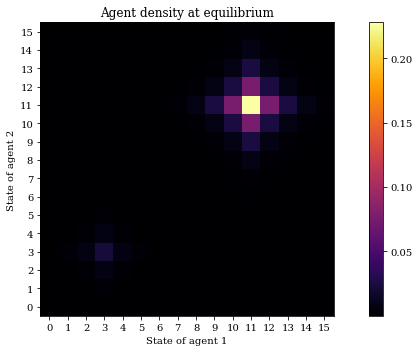

2


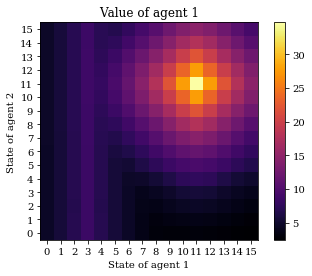

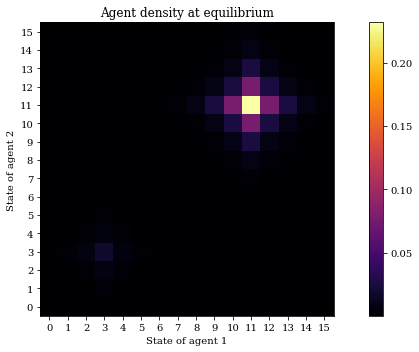

3


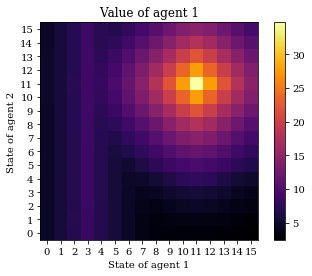

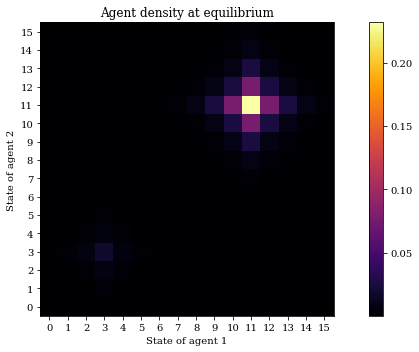

4


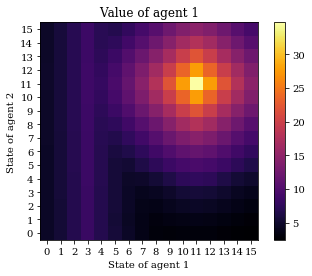

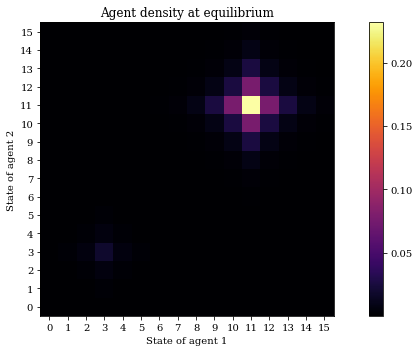

In [7]:
random_policy = np.ones((N*N,3))/3

CPT_k_pols = []
CPT_k_vals = []

CPT_k_opt_pols = []
CPT_k_opt_vals = []

for k in range(5):
    print(k)
    baseline_policy = random_policy if len(CPT_k_opt_pols)==0 else CPT_k_opt_pols[-1].copy()
    transformed_P1 = get_P1(P_both,swap_policy_owner(baseline_policy))
    vals, pols = CPT_value(N=N*N,P=transformed_P1,R=R1,beta=beta,baseline=baseline,
                           util_pos=util_pos,
                           util_neg=util_neg,
                           W_pos=w,
                           W_neg=w,
                           max_iter=200)
    _,opt_val,opt_pol = choose_best(vals,pols)
    CPT_k_pols.append(pols)
    CPT_k_vals.append(vals)
    CPT_k_opt_pols.append(opt_pol)
    CPT_k_opt_vals.append(opt_val)

    plt.figure()
    plt.title('Value of agent 1')
    plt.imshow(opt_val.reshape(N,N).T,cmap=cmap,origin='lower')
    plt.xlabel('State of agent 1')
    plt.ylabel('State of agent 2')
    plt.xticks(range(16))
    plt.yticks(range(16))
    plt.colorbar()
    plt.show()

    q = get_markov_chain(P_both,opt_pol,swap_policy_owner(opt_pol))
    plot_equilibrium_density(q)


In [77]:
pickle.dump(CPT_k_pols,    open(path+'/CPT/CPT_k_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))
pickle.dump(CPT_k_vals,    open(path+'/CPT/CPT_k_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))
pickle.dump(CPT_k_opt_pols,open(path+'/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))
pickle.dump(CPT_k_opt_vals,open(path+'/CPT/CPT_k_opt_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'wb'))

<center><h1>Results - Asymmetric Sophistication with Expected Utility Theory

In [23]:
random_policy = np.ones((N*N,3))/3

values_1 = []
values_2 = []

policies_1 = []
policies_2 = []

optimal_values_1 = []
optimal_values_2 = []

optimal_policies_1 = [swap_policy_owner(random_policy)]
optimal_policies_2 = [random_policy]


for k in range(5):
    
    print(f"Sophistication level k = {k}                                ")
    
    baseline_policy_1 = optimal_policies_2[-1].copy()
    baseline_policy_2 = optimal_policies_1[-1].copy()
    
    transformed_P1 = get_P1(P_both,baseline_policy_1)
    transformed_P2 = get_P2(P_both,baseline_policy_2)

    # Obtain values and policies of agent 1 when agent 1 has sophistication k1 and agent 2 has sophistication k2
    vals_1, pols_1 = CPT_value(N=N*N,P=transformed_P1,R=R1,beta=beta,baseline=baseline,
                           util_pos=util_pos,
                           util_neg=util_neg,
                           W_pos=lambda x:x,
                           W_neg=lambda x:x,
                           max_iter=max_iter,
                           stop_error=1e-2)

    _,opt_val_1,opt_pol_1 = choose_best(vals_1,pols_1)

    values_1.append(vals_1)
    policies_1.append(pols_1)

    optimal_values_1.append(opt_val_1)
    optimal_policies_1.append(opt_pol_1)


    # Obtain values and policies of agent 2 when agent 1 has sophistication k1 and agent 2 has sophistication k2
    vals_2, pols_2 = CPT_value(N=N*N,P=transformed_P2,R=R2,beta=beta,baseline=baseline,
                           util_pos=util_pos,
                           util_neg=util_neg,
                           W_pos=lambda x:x,
                           W_neg=lambda x:x,
                           max_iter=max_iter,
                           stop_error=0.5)

    _,opt_val_2,opt_pol_2 = choose_best(vals_2,pols_2)

    values_2.append(vals_2)
    policies_2.append(pols_2)

    optimal_values_2.append(opt_val_2)
    optimal_policies_2.append(opt_pol_2)




#     plt.figure()
#     plt.title('Value of agent 1')
#     plt.imshow(opt_val_1.reshape(N,N).T,cmap=cmap,origin='lower')
#     plt.xlabel('State of agent 1')
#     plt.ylabel('State of agent 2')
#     plt.xticks(range(16))
#     plt.yticks(range(16))
#     plt.colorbar()
#     plt.show()


#     plt.figure()
#     plt.title('Value of agent 2')
#     plt.imshow(opt_val_2.reshape(N,N).T,cmap=cmap,origin='lower')
#     plt.xlabel('State of agent 1')
#     plt.ylabel('State of agent 2')
#     plt.xticks(range(16))
#     plt.yticks(range(16))
#     plt.colorbar()
#     plt.show()

#     q = get_markov_chain(P_both,opt_pol_1,opt_pol_2)
#     plot_equilibrium_density(q)

Sophistication level k = 0                                
Sophistication level k = 1                                  
Sophistication level k = 2                                  
Sophistication level k = 3                                  
Sophistication level k = 4                                  


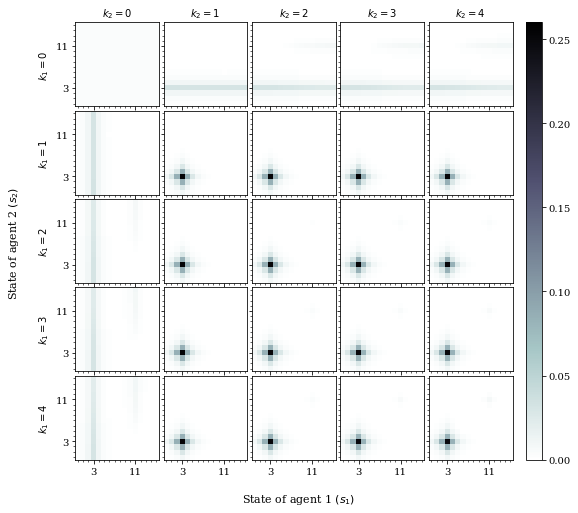

In [24]:
fig, axes = plt.subplots(5,5,figsize=(9,9),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)

for k1,axe in enumerate(axes):
    for k2,ax in enumerate(axe):
        if k2==0:
            ax.set_ylabel(r"$k_1="+str(k1)+"$")
            pass
        if k1==0:
            ax.set_xlabel(r"$k_2="+str(k2)+"$",labelpad=-100)
#             ax.set_title("k1")
            pass
        
        P_markov_chain = get_markov_chain(P_both,optimal_policies_1[k1],optimal_policies_2[k2])
    
        im = ax.imshow(get_agent_density(P_markov_chain,10000,initial_distribution = np.ones(N*N)/(N*N)).reshape(N,N).T,origin='lower',cmap="bone_r",vmin=0,vmax=0.26)

fig.subplots_adjust(hspace=-0.35,wspace=0.055,right=0.8)

cbar_ax = fig.add_axes([0.82, 0.165, 0.025, 0.675])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.02, 0.5, "State of agent 2 $(s_2)$", fontsize=11,rotation="vertical",  verticalalignment  ="center")
fig.text(0.47, 0.1, "State of agent 1 $(s_1)$", fontsize=11,rotation="horizontal",horizontalalignment="center")

plt.savefig("Concavity0.99/AsymmetricSophisticationsEUT.pdf",bbox_inches='tight')
plt.show()

<center><h1>Results - Asymmetric Sophistication with Cumulative Prospect Theory

In [25]:
random_policy = np.ones((N*N,3))/3

values_1 = []
values_2 = []

policies_1 = []
policies_2 = []

optimal_values_1 = []
optimal_values_2 = []

optimal_policies_1 = [swap_policy_owner(random_policy)]
optimal_policies_2 = [random_policy]


for k in range(5):
    
    print(f"Sophistication level k = {k}")
    
    baseline_policy_1 = optimal_policies_2[-1].copy()
    baseline_policy_2 = optimal_policies_1[-1].copy()
    
    transformed_P1 = get_P1(P_both,baseline_policy_1)
    transformed_P2 = get_P2(P_both,baseline_policy_2)

    # Obtain values and policies of agent 1 when agent 1 has sophistication k1 and agent 2 has sophistication k2
    vals_1, pols_1 = CPT_value(N=N*N,P=transformed_P1,R=R1,beta=beta,baseline=baseline,
                           util_pos=util_pos,
                           util_neg=util_neg,
                           W_pos=w,
                           W_neg=w,
                           max_iter=max_iter,
                           stop_error=0.5)

    _,opt_val_1,opt_pol_1 = choose_best(vals_1,pols_1)

    values_1.append(vals_1)
    policies_1.append(pols_1)

    optimal_values_1.append(opt_val_1)
    optimal_policies_1.append(opt_pol_1)


    # Obtain values and policies of agent 2 when agent 1 has sophistication k1 and agent 2 has sophistication k2
    vals_2, pols_2 = CPT_value(N=N*N,P=transformed_P2,R=R2,beta=beta,baseline=baseline,
                           util_pos=util_pos,
                           util_neg=util_neg,
                           W_pos=w,
                           W_neg=w,
                           max_iter=max_iter,
                           stop_error=0.5)

    _,opt_val_2,opt_pol_2 = choose_best(vals_2,pols_2)

    values_2.append(vals_2)
    policies_2.append(pols_2)

    optimal_values_2.append(opt_val_2)
    optimal_policies_2.append(opt_pol_2)

#     plt.figure()
#     plt.title('Value of agent 1')
#     plt.imshow(opt_val_1.reshape(N,N).T,cmap=cmap,origin='lower')
#     plt.xlabel('State of agent 1')
#     plt.ylabel('State of agent 2')
#     plt.xticks(range(16))
#     plt.yticks(range(16))
#     plt.colorbar()
#     plt.show()


#     plt.figure()
#     plt.title('Value of agent 2')
#     plt.imshow(opt_val_2.reshape(N,N).T,cmap=cmap,origin='lower')
#     plt.xlabel('State of agent 1')
#     plt.ylabel('State of agent 2')
#     plt.xticks(range(16))
#     plt.yticks(range(16))
#     plt.colorbar()
#     plt.show()

#     q = get_markov_chain(P_both,opt_pol_1,opt_pol_2)
#     plot_equilibrium_density(q)


Sophistication level k = 0
Sophistication level k = 1 1322.775                                             
Sophistication level k = 2 1608.310                                             
Sophistication level k = 3 1624.652                                             
Sophistication level k = 4 1624.692                                             


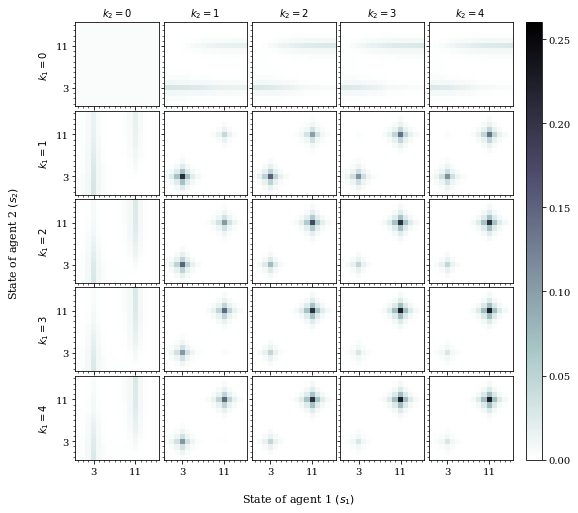

In [26]:
fig, axes = plt.subplots(5,5,figsize=(9,9),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)

for k1,axe in enumerate(axes):
    for k2,ax in enumerate(axe):
        if k2==0:
            ax.set_ylabel(r"$k_1="+str(k1)+"$")
            pass
        if k1==0:
            ax.set_xlabel(r"$k_2="+str(k2)+"$",labelpad=-100)
#             ax.set_title("k1")
            pass
        
        P_markov_chain = get_markov_chain(P_both,optimal_policies_1[k1],optimal_policies_2[k2])
    
        im = ax.imshow(get_agent_density(P_markov_chain,10000,initial_distribution = np.ones(N*N)/(N*N)).reshape(N,N).T,origin='lower',cmap="bone_r",vmin=0,vmax=0.26)

fig.subplots_adjust(hspace=-0.35,wspace=0.055,right=0.8)

cbar_ax = fig.add_axes([0.82, 0.165, 0.025, 0.675])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.02, 0.5, "State of agent 2 $(s_2)$", fontsize=11,rotation="vertical",  verticalalignment  ="center")
fig.text(0.47, 0.1, "State of agent 1 $(s_1)$", fontsize=11,rotation="horizontal",horizontalalignment="center")

plt.savefig("Concavity0.99/AsymmetricSophisticationsCPT.pdf",bbox_inches='tight')
plt.show()

<center><h1>Results - Asymmetric Sophistication with Expected Utility Theory & Cumulative Prospect Theory

In [27]:
random_policy = np.ones((N*N,3))/3

values_1 = []
values_2 = []

policies_1 = []
policies_2 = []

optimal_values_1 = []
optimal_values_2 = []

optimal_policies_1 = [swap_policy_owner(random_policy)]
optimal_policies_2 = [random_policy]


for k in range(5):
    
    print(f"Sophistication level k = {k}")
    
    baseline_policy_1 = optimal_policies_2[-1].copy()
    baseline_policy_2 = optimal_policies_1[-1].copy()
    
    transformed_P1 = get_P1(P_both,baseline_policy_1)
    transformed_P2 = get_P2(P_both,baseline_policy_2)

    # Obtain values and policies of agent 1 when agent 1 has sophistication k1 and agent 2 has sophistication k2
    vals_1, pols_1 = CPT_value(N=N*N,P=transformed_P1,R=R1,beta=beta,baseline=baseline,
                           util_pos=util_pos,
                           util_neg=util_neg,
                           W_pos=lambda x:x,
                           W_neg=lambda x:x,
                           max_iter=max_iter,
                           stop_error=0.5)

    _,opt_val_1,opt_pol_1 = choose_best(vals_1,pols_1)

    values_1.append(vals_1)
    policies_1.append(pols_1)

    optimal_values_1.append(opt_val_1)
    optimal_policies_1.append(opt_pol_1)


    # Obtain values and policies of agent 2 when agent 1 has sophistication k1 and agent 2 has sophistication k2
    vals_2, pols_2 = CPT_value(N=N*N,P=transformed_P2,R=R2,beta=beta,baseline=baseline,
                           util_pos=util_pos,
                           util_neg=util_neg,
                           W_pos=w,
                           W_neg=w,
                           max_iter=max_iter,
                           stop_error=0.5)

    _,opt_val_2,opt_pol_2 = choose_best(vals_2,pols_2)

    values_2.append(vals_2)
    policies_2.append(pols_2)

    optimal_values_2.append(opt_val_2)
    optimal_policies_2.append(opt_pol_2)

#     plt.figure()
#     plt.title('Value of agent 1')
#     plt.imshow(opt_val_1.reshape(N,N).T,cmap=cmap,origin='lower')
#     plt.xlabel('State of agent 1')
#     plt.ylabel('State of agent 2')
#     plt.xticks(range(16))
#     plt.yticks(range(16))
#     plt.colorbar()
#     plt.show()


#     plt.figure()
#     plt.title('Value of agent 2')
#     plt.imshow(opt_val_2.reshape(N,N).T,cmap=cmap,origin='lower')
#     plt.xlabel('State of agent 1')
#     plt.ylabel('State of agent 2')
#     plt.xticks(range(16))
#     plt.yticks(range(16))
#     plt.colorbar()
#     plt.show()

#     q = get_markov_chain(P_both,opt_pol_1,opt_pol_2)
#     plot_equilibrium_density(q)
    
    


Sophistication level k = 0
Sophistication level k = 1 1323.147                                             
Sophistication level k = 2 1550.315                                             
Sophistication level k = 3 1592.141                                             
Sophistication level k = 4 1592.525                                             


(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)

(16, 16)
(16, 16)



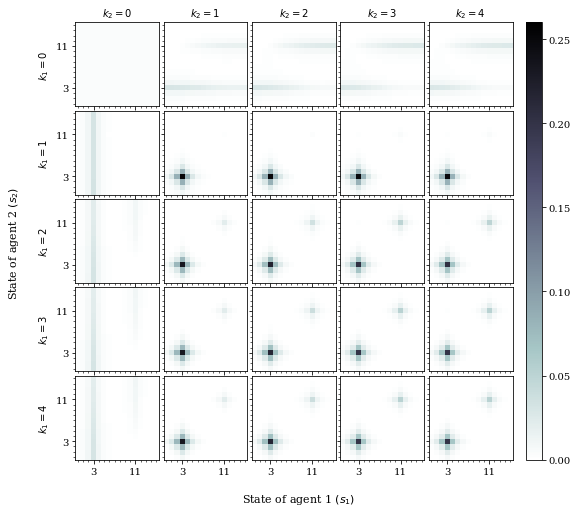

In [28]:
fig, axes = plt.subplots(5,5,figsize=(9,9),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)

for k1,axe in enumerate(axes):
    for k2,ax in enumerate(axe):
        if k2==0:
            ax.set_ylabel(r"$k_1="+str(k1)+"$")
            pass
        if k1==0:
            ax.set_xlabel(r"$k_2="+str(k2)+"$",labelpad=-100)
#             ax.set_title("k1")
            pass
        
        P_markov_chain = get_markov_chain(P_both,optimal_policies_1[k1],optimal_policies_2[k2])
        density = get_agent_density(P_markov_chain,10000,initial_distribution = np.ones(N*N)/(N*N)).reshape(N,N).T
        print(density.shape)
        print(R1.reshape(N,N).T.shape)
        print()
        im = ax.imshow(density,origin='lower',cmap="bone_r",vmin=0,vmax=0.26)

fig.subplots_adjust(hspace=-0.35,wspace=0.055,right=0.8)

cbar_ax = fig.add_axes([0.82, 0.165, 0.025, 0.675])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.02, 0.5, "State of agent 2 $(s_2)$", fontsize=11,rotation="vertical",  verticalalignment  ="center")
fig.text(0.47, 0.1, "State of agent 1 $(s_1)$", fontsize=11,rotation="horizontal",horizontalalignment="center")

plt.savefig("Concavity0.99/AsymmetricSophisticationsEUTandCPT.pdf",bbox_inches='tight')
plt.show()

<h3><center> Load Pickles if already run

In [79]:
EUT_k_pols     = pickle.load(open(path+'./EUT/EUT_k_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
EUT_k_vals     = pickle.load(open(path+'./EUT/EUT_k_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
EUT_k_opt_pols = pickle.load(open(path+'./EUT/EUT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
EUT_k_opt_vals = pickle.load(open(path+'./EUT/EUT_k_opt_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))

CPT_k_pols     = pickle.load(open(path+'./CPT/CPT_k_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
CPT_k_vals     = pickle.load(open(path+'./CPT/CPT_k_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
CPT_k_opt_pols = pickle.load(open(path+'./CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
CPT_k_opt_vals = pickle.load(open(path+'./CPT/CPT_k_opt_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))

<h1><center>Create Figures

<h2><center>CPT Value & Policy

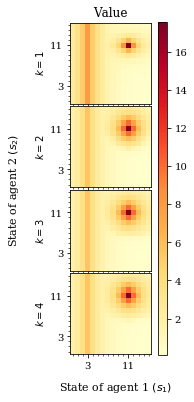

In [31]:
fig, axes = plt.subplots(4,1,figsize=(5/3,9),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)
    
for k,(ax) in enumerate(axes):
    if k==4:
        break
    
    if k==0:
        ax.set_title("Value")
    
    ax.set_ylabel("$k={}$".format(k+1))

    d = CPT_k_opt_vals[k].reshape(N,N).T
    im = ax.imshow(d,cmap='YlOrRd',origin='lower')#,vmin=0,vmax=35)

fig.subplots_adjust(hspace=-0.65,wspace=0.1,right=0.8)

    
cbar_ax = fig.add_axes([0.86, 0.245, 0.025*3, 0.514])
fig.colorbar(im, cax=cbar_ax)
fig.text(-0.4, 0.5, "State of agent 2 $(s_2)$", fontsize=11,rotation="vertical",  verticalalignment  ="center")
fig.text(0.5, 0.19, "State of agent 1 $(s_1)$", fontsize=11,rotation="horizontal",horizontalalignment="center")
# plt.savefig("Concavity0.99/MarkovValue.pdf",bbox_inches='tight')
plt.show()


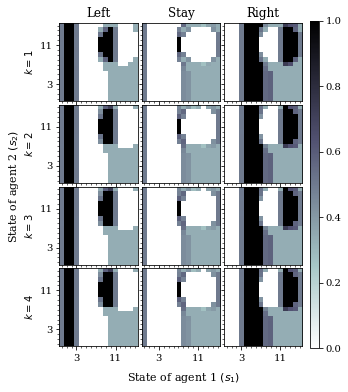

In [40]:
fig, axes = plt.subplots(4,3,figsize=(5,9),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)

for k,axe in enumerate(axes):
    for a,ax in enumerate(axe):
        if a==0:
            ax.set_ylabel("$k={}$".format(k+1))
            pass
        if k==0:
            ax.set_title(["Left","Stay","Right"][a])
        
        im = ax.imshow(EUT_k_opt_pols[k].T.reshape(3,N,N)[a].T,origin="lower",cmap="bone_r")

fig.subplots_adjust(hspace=-0.665,wspace=0.055,right=0.8)

cbar_ax = fig.add_axes([0.82, 0.25, 0.025, 0.506])
fig.colorbar(im, cax=cbar_ax)

fig.text(-0.02, 0.5, "State of agent 2 $(s_2)$", fontsize=11,rotation="vertical",  verticalalignment  ="center")
fig.text(0.47, 0.2, "State of agent 1 $(s_1)$", fontsize=11,rotation="horizontal",horizontalalignment="center")

plt.savefig("Rebuttalv2/MarkovPolicyEUT.pdf",bbox_inches='tight')
plt.show()


<h2><center>EUT vs CPT Value Comparison

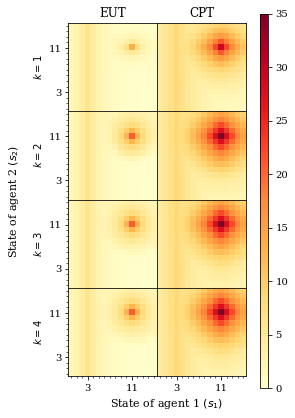

In [12]:
A_opt_vals = pickle.load(open('pickles/EUT/EUT_k_opt_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
B_opt_vals = pickle.load(open('pickles/CPT/CPT_k_opt_vals_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))

N_opt_vals = [A_opt_vals,B_opt_vals]
N_titles   = ["EUT","CPT"]

vmax=np.max(np.concatenate((N_opt_vals)))

# ---------------------------------------------------------------------------------------

fig, axes = plt.subplots(4,len(N_opt_vals),figsize=(7.4/2,6.5),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)

for k,(ax) in enumerate(axes):
    if k==4:
        break

    for i,(a,d) in enumerate(zip(ax,np.array(N_opt_vals).transpose(1,0,2)[k])):
        im = a.imshow(d.reshape(N,N).T,cmap='YlOrRd',origin='lower',vmin=0,vmax=35)
        
        if k==0:
            a.set_title(N_titles[i])
        if i == 0:
            a.set_ylabel("$k={}$".format(k+1))
        if not k==3:
            a.xaxis.set_ticks_position('none')             
        if not i==0:
            a.yaxis.set_ticks_position('none')

fig.subplots_adjust(hspace=0,wspace=-.015,right=0.8)

cbar_ax = fig.add_axes([0.85, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cbar_ax)
fig.text(-0.1, 0.5, "State of agent 2 $(s_2)$", fontsize=11,rotation="vertical",  verticalalignment  ="center")
fig.text(0.5, 0.06, "State of agent 1 $(s_1)$", fontsize=11,rotation="horizontal",horizontalalignment="center")

plt.savefig('loss_aversion_2/EUTandCPTValues.pdf'.format(k+1),bbox_inches='tight')
plt.show()

<h1><center> Discount Factor Sensitivity

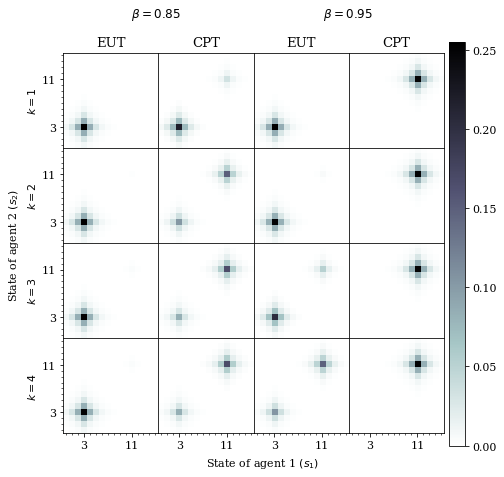

In [259]:
A_opt_pols = pickle.load(open('./discountFactor .85/pickles/EUT/EUT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
B_opt_pols = pickle.load(open('./discountFactor .85/pickles/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))

C_opt_pols = pickle.load(open('./discountFactor .95/pickles/EUT/EUT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
D_opt_pols = pickle.load(open('./discountFactor .95/pickles/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))

N_opt_pols = [A_opt_pols,B_opt_pols,C_opt_pols,D_opt_pols]
N_titles   = ["EUT","CPT","EUT","CPT"]
N_densities = []
for opt_pols in N_opt_pols:
    densities = []
    for k,pol in enumerate(opt_pols):
#         print(k)
        q = get_markov_chain(P_both,pol,swap_policy_owner(pol))
        density = get_agent_density(q,99999999,np.ones(N*N)/(N*N)).reshape(N,N)
        densities.append(density)
        densities[k]=densities[k]/np.sum(densities[k])
    N_densities.append(densities)
    
vmax=np.max(np.concatenate((N_densities)))
vmax

# ---------------------------------------------------------------------------------------

fig, axes = plt.subplots(4,len(N_densities),figsize=(7.4,7),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)

for k,(ax) in enumerate(axes):
    if k==4:
        break
    
    for i,(a,d) in enumerate(zip(ax,np.array(N_densities).transpose(1,0,2,3)[k])):
        im = a.imshow(d.reshape(N,N).T,cmap='bone_r',origin='lower',vmin=0,vmax=vmax)
        
        if k==0:
            a.set_title(N_titles[i])
        if i == 0:
            a.set_ylabel("$k={}$".format(k+1))
        if not k==3:
            a.xaxis.set_ticks_position('none')             
        if not i==0:
            a.yaxis.set_ticks_position('none')

fig.subplots_adjust(hspace=0,wspace=0,right=0.84)

cbar_ax = fig.add_axes([0.85, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cbar_ax)
fig.text(0.02, 0.5, "State of agent 2 $(s_2)$", fontsize=11,rotation="vertical",  verticalalignment  ="center")
fig.text(0.5, 0.06, "State of agent 1 $(s_1)$", fontsize=11,rotation="horizontal",horizontalalignment="center")

fig.text(0.3, 0.95, r"$\beta=0.85$", fontsize=12,rotation="horizontal",horizontalalignment="center")
fig.text(0.66, 0.95, r"$\beta=0.95$", fontsize=12,rotation="horizontal",horizontalalignment="center")

plt.savefig('MarkovGame/rf_densitiesV2.pdf'.format(k+1),bbox_inches='tight')
plt.show()

In [260]:
EUT_k_densities = []
for k,pol in enumerate(EUT_k_opt_pols):
    q = get_markov_chain(P_both,pol,swap_policy_owner(pol))
    density = get_agent_density(q,99999999,np.ones(N*N)/(N*N)).reshape(N,N)
    EUT_k_densities.append(density)
    EUT_k_densities[k]=EUT_k_densities[k]/np.sum(EUT_k_densities[k])

CPT_k_densities = []
for k,pol in enumerate(CPT_k_opt_pols):
    q = get_markov_chain(P_both,pol,swap_policy_owner(pol))
    density = get_agent_density(q,99999999,np.ones(N*N)/(N*N)).reshape(N,N)
    CPT_k_densities.append(density)
    CPT_k_densities[k]=CPT_k_densities[k]/np.sum(CPT_k_densities[k])
vmax=np.max(np.concatenate((CPT_k_densities,EUT_k_densities)))

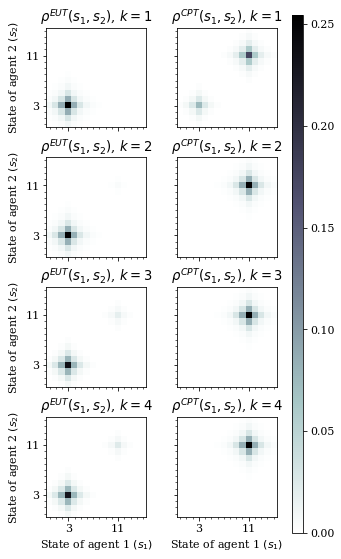

In [261]:

fig, axes = plt.subplots(4,2,figsize=(5,9),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)

for k,((ax_EUT,ax_CPT),density_EUT,density_CPT) in enumerate(zip(axes,EUT_k_densities,CPT_k_densities)):
    if k==4:
        break

    im = ax_EUT.imshow(density_EUT.reshape(N,N).T,cmap='bone_r',origin='lower',vmin=0,vmax=vmax)
    im = ax_CPT.imshow(density_CPT.reshape(N,N).T,cmap='bone_r',origin='lower',vmin=0,vmax=vmax)
    
    if k==3:
        ax_EUT.set_xlabel(r'State of agent 1 $(s_1)$')
        ax_CPT.set_xlabel(r'State of agent 1 $(s_1)$')
    ax_EUT.set_ylabel(r'State of agent 2 $(s_2)$')
    
    ax_EUT.set_title(r'$\rho^{{EUT}}(s_1,s_2)$, $k={}$'.format(k+1))
    ax_CPT.set_title(r'$\rho^{{CPT}}(s_1,s_2)$, $k={}$'.format(k+1))

fig.subplots_adjust(hspace=0.3,wspace=0,right=0.85)

cbar_ax = fig.add_axes([0.85, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('MarkovGame/densities.pdf'.format(k+1),bbox_inches='tight')
plt.show()

<h1><center> Reference Point Sensitivity

In [262]:
rp_n1_k_opt_pols = pickle.load(open('./referencePoint -1/pickles/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
rp_0_opt_pols    = pickle.load(open('./referencePoint 0/pickles/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
rp_1_opt_pols    = pickle.load(open('./referencePoint +1/pickles/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))
rp_2_opt_pols    = pickle.load(open('./referencePoint +2/pickles/CPT/CPT_k_opt_pols_{}_{}.pickle'.format(hare_reward,stag_reward),'rb'))

In [263]:
N_opt_pols = [rp_n1_k_opt_pols,rp_0_opt_pols,rp_1_opt_pols,rp_2_opt_pols]
N_titles   = [r"$b=-1$",r"$b=0$",r"$b=1$",r"$b=2$"]
N_densities = []
for opt_pols in N_opt_pols:
    densities = []
    for k,pol in enumerate(opt_pols):
        q = get_markov_chain(P_both,pol,swap_policy_owner(pol))
        density = get_agent_density(q,99999999,np.ones(N*N)/(N*N)).reshape(N,N)
        densities.append(density)
        densities[k]=densities[k]/np.sum(densities[k])
    N_densities.append(densities)
    
vmax=np.max(np.concatenate((N_densities)))

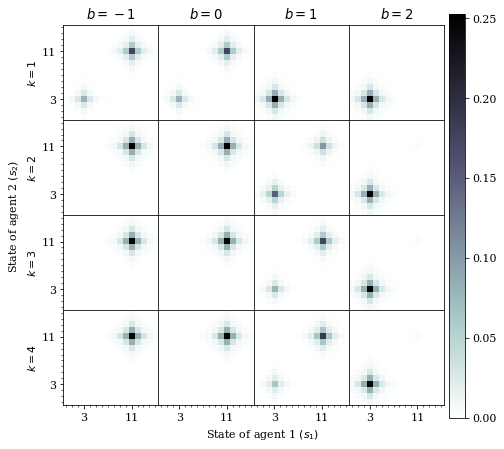

In [265]:
fig, axes = plt.subplots(4,len(N_densities),figsize=(7.4,7),sharey=True,sharex=True)
for ax in axes.ravel():
    ax.set_xticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_xticks([3,11], minor=False)
    ax.set_yticks([0,1,2,4,5,6,7,8,9,10,12,13,14,15], minor=True)
    ax.set_yticks([3,11], minor=False)

for k,(ax) in enumerate(axes):
    if k==4:
        break
    
    for i,(a,d) in enumerate(zip(ax,np.array(N_densities).transpose(1,0,2,3)[k])):
        im = a.imshow(d.reshape(N,N).T,cmap='bone_r',origin='lower',vmin=0,vmax=vmax)
        
        if k==0:
            a.set_title(N_titles[i])
        if i == 0:
            a.set_ylabel("$k={}$".format(k+1))
        if not k==3:
            a.xaxis.set_ticks_position('none')             
        if not i==0:
            a.yaxis.set_ticks_position('none')

fig.subplots_adjust(hspace=0,wspace=0,right=0.84)

cbar_ax = fig.add_axes([0.85, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cbar_ax)
fig.text(0.02, 0.5, "State of agent 2 $(s_2)$", fontsize=11,rotation="vertical",  verticalalignment  ="center")
fig.text(0.5, 0.06, "State of agent 1 $(s_1)$", fontsize=11,rotation="horizontal",horizontalalignment="center")

plt.savefig('MarkovGame/rp_densities.pdf'.format(k+1),bbox_inches='tight')
plt.show()